In [1]:
## import all pakcage
# General Imports
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Building Model
from keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import legacy

# Training Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint


# Data Processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array


2024-11-28 17:46:23.340708: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732787183.349623   12718 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732787183.352154   12718 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-28 17:46:23.360582: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
## load model 
test_model = tf.keras.models.load_model('without_optimizar/multiclass_0.973.keras')



I0000 00:00:1732787184.736709   12718 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13382 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Ti SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


In [3]:
## load testing dataset
# Image Size
image_size = (150,150)

#Training batch size
batch_size = 32

CLASS_TYPES = ["glioma","meningioma","notumor","pituitary"]
TYPES = 4

root = r"Brain-Tumor-Classification-DataSet"
test_path = root + "/Training"
train_path = root + "/Testing"

test_datagen =  ImageDataGenerator(rescale=1./255)

test_dataset = test_datagen.flow_from_directory(test_path,
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  class_mode="categorical",
                                                  shuffle=False,
                                                  seed=105)




Found 2870 images belonging to 4 classes.


In [4]:
## model predict

loss, accuracy = test_model.evaluate(test_dataset, steps=test_dataset.samples//batch_size)
print(f"Test Loss: {loss:0.5f}")
print(f"Test Accuracy: {accuracy:0.5f}")

/home/user/miniconda3/envs/tensorflow/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1732787186.746868   12848 service.cc:148] XLA service 0x7fb840008bc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732787186.746894   12848 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti SUPER, Compute Capability 8.9
2024-11-28 17:46:26.755369: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732787186.776403   12848 cuda_dnn.cc:529] Loaded cuDNN version 90300


 4/89 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.9733 - loss: 0.0421

I0000 00:00:1732787187.918176   12848 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.9755 - loss: 0.0648
Test Loss: 0.05678
Test Accuracy: 0.98209


90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step


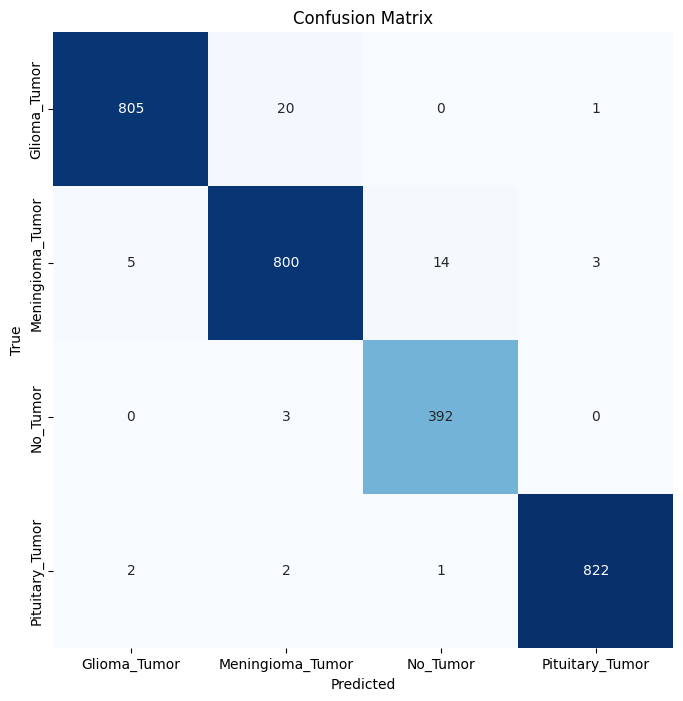

In [5]:
## plot confusion matrix 
def plot_sample_predictions(model, test_generator, categories, test_dir, num_samples=9, figsize=(12, 8)):
    # Make predictions on the test dataset
    predictions = model.predict(test_generator)
    predicted_categories = np.argmax(predictions, axis=1)
    true_categories = test_generator.classes

    # Randomly sample test images
    test_images = np.array(test_generator.filepaths)
    sample_indices = np.random.choice(len(test_images), size=num_samples, replace=False)
    sample_images = test_images[sample_indices]
    sample_predictions = [categories[predicted_categories[i]] for i in sample_indices]
    sample_true_labels = [categories[true_categories[i]] for i in sample_indices]

    # Plot sample images with their predicted and true labels
    plt.figure(figsize=figsize)
    
    # Loop over samples
    for i, image_path in enumerate(sample_images):
        # Form subplot and plot
        plt.subplot(3, 3, i + 1)
        img = plt.imread(image_path)
        plt.imshow(img)
        plt.axis("off")
        
        # Set axis label color depending on correct prediction or not
        prediction_color = 'green' if sample_predictions[i] == sample_true_labels[i] else 'red'
        plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}", color=prediction_color)
        
    plt.tight_layout()
    plt.show()


def CM(CNN_model, test_generator, categories):
   
    from sklearn.metrics import confusion_matrix
    # Predictions on test dataset
    predictions = CNN_model.predict(test_generator)
    predicted_categories = np.argmax(predictions, axis=1)
    true_categories = test_generator.classes

    # Create a confusion matrix
    confusion_matrix_array = confusion_matrix(true_categories, predicted_categories)
    
    return confusion_matrix_array

def calculate_metrics(confusion_matrix, categories):
    # Calculating 4 different metrics
    precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
    recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy = np.sum(np.diag(confusion_matrix)) / np.sum(confusion_matrix)

    # Printing the results based on each category
    for i, category in enumerate(categories):
        print(f"Class: {category.title()}")
        print(f"Precision: {precision[i]:.3f}")
        print(f"Recall: {recall[i]:.3f}")
        print(f"F1-Score: {f1_score[i]:.3f}\n")
        
    # Showing the total accuracy of the model
    print(f"\nAccuracy: {accuracy:.3f}")

    
    # Plotting confusion matrix
class_indices_train_list = list(test_dataset.class_indices.keys())
confusion_matrix = CM(CNN_model=test_model, test_generator=test_dataset, categories=class_indices_train_list)

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(4) + 0.5,
           labels=[name.title() for name in class_indices_train_list], ha='center')
plt.yticks(ticks=np.arange(4) + 0.5, 
           labels=[name.title() for name in class_indices_train_list], va='center')
plt.show()

In [6]:
calculate_metrics(confusion_matrix, categories=class_indices_train_list)

Class: Glioma_Tumor
Precision: 0.991
Recall: 0.975
F1-Score: 0.983

Class: Meningioma_Tumor
Precision: 0.970
Recall: 0.973
F1-Score: 0.971

Class: No_Tumor
Precision: 0.963
Recall: 0.992
F1-Score: 0.978

Class: Pituitary_Tumor
Precision: 0.995
Recall: 0.994
F1-Score: 0.995


Accuracy: 0.982
